# Cold Plasma Tensor Elements in ICRF

Let's assume the following form of the cold plasma dielectric tensor :
$$
\mathbf{K}
=
\left(
\begin{array}{ccc}
S & j D & 0 \\
-j D & S & 0 \\
0 & 0 & P
\end{array}
\right)
$$
where
$$
\begin{eqnarray}
S &=& 1 - \sum_s \frac{\omega_{p,s}^2}{\omega^2 - \Omega_{c,s}^2} \\
D &=& \sum_s \frac{\Omega_{c,s}}{\omega} \frac{\omega_{p,s}^2}{\omega^2 - \Omega_{c,s}^2} \\
P &=& 1 - \sum_s \frac{\omega_{p,s}^2}{\omega^2}
\end{eqnarray}
$$

In [33]:
from scipy.constants import e, epsilon_0
import os
import sys
# import plasmapy, currently not in the python path
sys.path.append('../PlasmaPy')
import plasmapy as pp
import astropy.units as u 
import numpy as np
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [59]:
B = 2.3 * u.T
n_e = 1e18 * u.m**-3
n_i = 1e18 * u.m**-3

omega_ce = -1*pp.physics.gyrofrequency(B=B, particle='e')
omega_ci = pp.physics.gyrofrequency(B=B, particle='D+')
omega_pe = pp.physics.plasma_frequency(n=n_e, particle='e')
omega_pi = pp.physics.plasma_frequency(n=n_i, particle='D+')

In [22]:
omega_RF = 50*1e6*(2*np.pi)*(u.rad/u.s) # pay attention to the unit in rad/s!

In [54]:
from plasmapy.utils import check_quantity 
@check_quantity({
    'n_i': {'units': u.m**-3, 'can_be_negative': False},
    'n_e': {'units': u.m**-3, 'can_be_negative': False},
    'omega': {'units': u.rad/u.s, 'can_be_negative': False},
    'B': {'units': u.T, 'can_be_negative': False}
})
def cold_plasma_tensor(n_i, n_e, omega, B, ions=['D+', 'H+'], ratio=[0.95,0.05]):
    # electron contributions
    omega_ce = -pp.physics.gyrofrequency(B=B, particle='e')
    omega_pe = pp.physics.plasma_frequency(n=n_e, particle='e')
    
    S = 1 - omega_pe**2 / (omega**2 - omega_ce**2) 
    D =   omega_ce/omega * omega_pe**2 / (omega**2 - omega_ce**2)
    P = 1 - omega_pe**2 / omega**2
    
    # ion contributions
    for (s, prop) in zip(ions, ratio):
        omega_ci = pp.physics.gyrofrequency(B=B, particle=s)
        omega_pi = pp.physics.plasma_frequency(n=prop*n_i, particle=s)
        
        S -= omega_pi**2 / (omega**2 - omega_ci**2)
        D += omega_ci/omega * omega_pi**2 / (omega**2 - omega_ci**2)
        P -= omega_ci**2 / omega**2
    
    return S, D, P # S,D and P has no unit (to be checked)

In [107]:
omega_RF = np.logspace(start=6, stop=10, num=2001)*(2*np.pi)*(u.rad/u.s)

In [108]:
S,D,P = cold_plasma_tensor(n_i=1.7e17*u.m**-3, n_e=1.7e17*u.m**-3, 
                           omega=omega_RF, B=B, ions=['D+'], ratio=[1])

Text(0.5,1,'Stix parameters for B=2.3 T, $n_e$=$n_i$=1e+18 1 / m3')

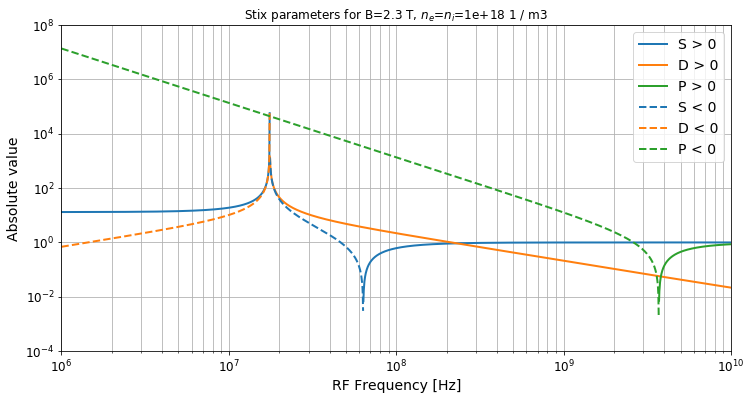

In [120]:
plt.figure(figsize=(12,6))
semilogx(omega_RF/(2*pi)*(S>0), abs(S)*(S>0), 
      omega_RF/(2*pi)*(D>0), abs(D)*(D>0), 
      omega_RF/(2*pi)*(P>0), abs(P)*(P>0), lw=2)
semilogx(omega_RF/(2*pi)*(S<0), abs(S)*(S<0), '#1f77b4', 
      omega_RF/(2*pi)*(D<0), abs(D)*(D<0), '#ff7f0e',
      omega_RF/(2*pi)*(P<0), abs(P)*(P<0),  '#2ca02c', lw=2, ls='--')
yscale('log')
grid(True, which='major')
grid(True, which='minor')
ylim(1e-4, 1e8)
xlim(1e6, 1e10)
legend(('S > 0','D > 0','P > 0','S < 0','D < 0','P < 0'), fontsize=14)
xlabel('RF Frequency [Hz]', size=14)
ylabel('Absolute value', size=14)
tick_params(labelsize=12)
title('Stix parameters for B={}, $n_e$=$n_i$={}'.format(B, n_e))

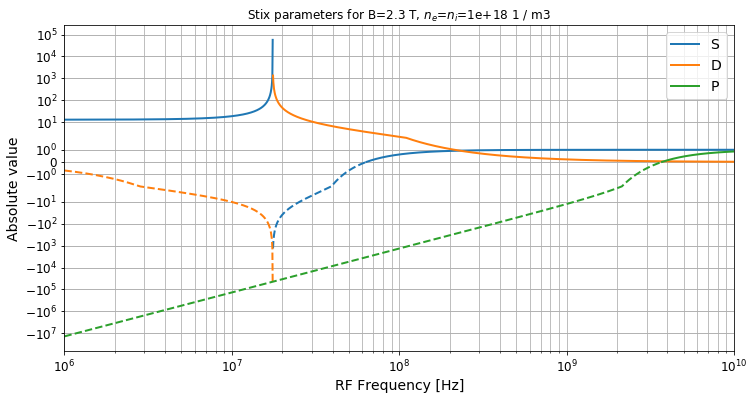

In [115]:
plt.figure(figsize=(12,6))
title('Stix parameters for B={}, $n_e$=$n_i$={}'.format(B, n_e))
semilogx(omega_RF/(2*pi)*(S>0), S*(S>0), 
      omega_RF/(2*pi)*(D>0), D*(D>0), 
      omega_RF/(2*pi)*(P>0), P*(P>0), lw=2)
semilogx(omega_RF/(2*pi)*(S<0), S*(S<0), '#1f77b4', 
      omega_RF/(2*pi)*(D<0), D*(D<0), '#ff7f0e',
      omega_RF/(2*pi)*(P<0), P*(P<0),  '#2ca02c', lw=2, ls='--')
grid(True, which='major')
grid(True, which='minor')
xlim(1e6, 1e10)
legend(('S','D','P'), fontsize=14)
yscale('symlog')
xlabel('RF Frequency [Hz]', size=14)
ylabel('Absolute value', size=14)
tick_params(labelsize=12)